# Usage Patterns Across Income Groups
---

In [1]:
library(RSQLCipher)
suppressMessages(library(lubridate))
suppressWarnings(suppressMessages(library(tidyverse)))

# import income functions
suppressMessages(source("../../src/income.R"))

select = dplyr::select

In [2]:
Sys.setenv("SQL_KEY"=Sys.getenv("HOT_KEY"))
options(repr.plot.width=10, repr.plot.height=6)

In [3]:
db_path = "../../../data/hot.db"

# import tables
#acs = load_table(db_path, "acs") %>% execute
acs = read_csv("../../data/acs/block_group_census_estimates_wide_wsdot_bins.csv", col_types="dccciiddddddddddddddddddd")

In [4]:
# will complain!
trips.2pct = load_table(db_path, "trips_2pct") %>%
    execute(col_types="ddddddddcccccdcldddddddd")

## What is the distribution of income in the travel shed, among paying users, and among HOV users?

In [326]:
suppressMessages(source("../../src/income.R"))

In [335]:
inc_shares_metro = acs %>% 
    filter(county_name == "King" | county_name == "Snohomish") %>%
    mutate(group="Metro area") %>%
    inc_distr_by(group, weight=population)
inc_shares_hot = trips.2pct %>%
    mutate(group=if_else(is_hov==1, "HOV users", "Paying users")) %>%
    inc_distr_by(group)
inc_shares = bind_rows(inc_shares_metro, inc_shares_hot)

metro_counts = inc_shares %>%
    gather(inc_group, pct, -group, -count) %>%
    mutate(count = count*pct) %>%
    filter(group == "Metro area") %>%
    pull(count)
med_metro = 1000 * median(fit_weibull(metro_counts, acs_bins))

metro_qiles = inc_shares_metro %>%
    gather(inc_group, pct, -group, -count) %>%
    group_by(group) %>%
    est_quantiles(c(0.05, 0.25, 0.5, 0.75, 0.95), pct*count)
metro_qiles

group,count,est_05,est_25,est_50,est_75,est_95,med_se
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Metro area,2887633,11574.44,43138.98,84385.34,143202.7,257801.4,45.31325


In [408]:
inc_shares

group,inc_000_035k,inc_035_050k,inc_050_075k,inc_075_100k,inc_100_125k,inc_125_150k,inc_150_200k,inc_200_infk,count
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Metro area,0.1918719,0.09955718,0.1584205,0.1335936,0.1126160,0.08079322,0.1012341,0.1210865,2890023
HOV users,0.1485179,0.08666906,0.1508638,0.1377062,0.1280385,0.09129310,0.1222458,0.1346658,58804
Paying users,0.1543340,0.08508388,0.1495774,0.1361534,0.1230493,0.09035092,0.1205149,0.1409362,141196


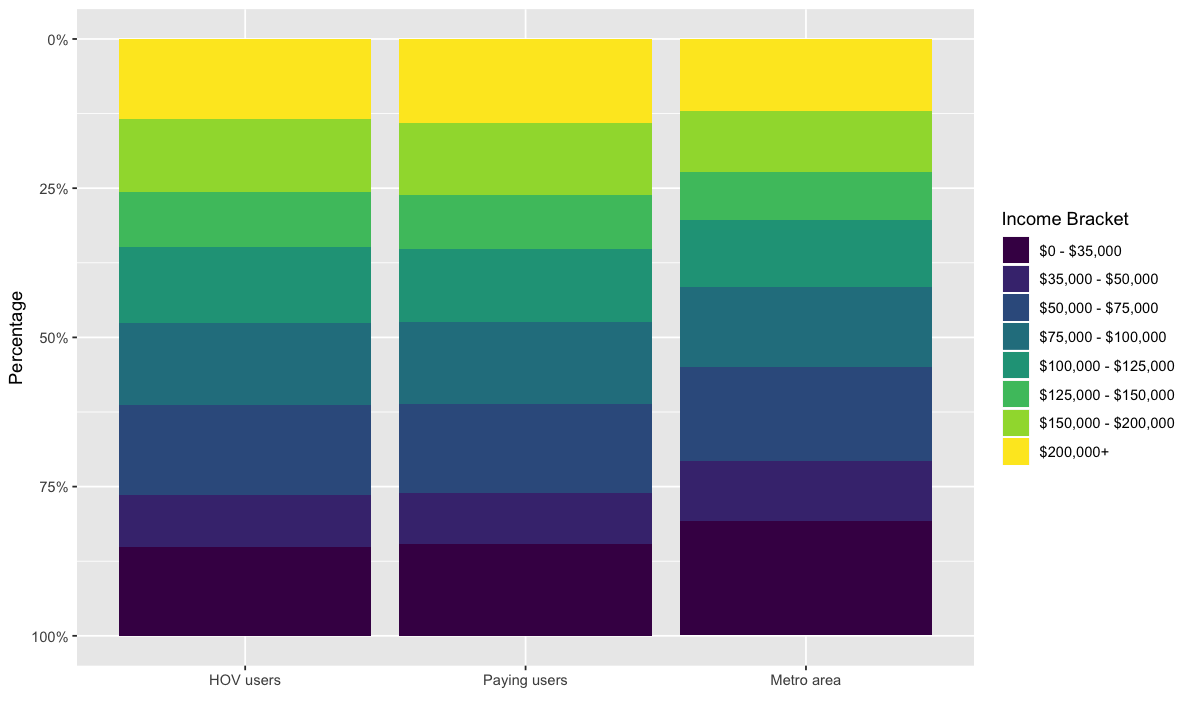

In [327]:
inc_shares %>%
    mutate(group = fct_reorder(group, inc_000_035k)) %>%
    plot_inc_stacked(xlab="")

## What is the distribution of income by use frequency?

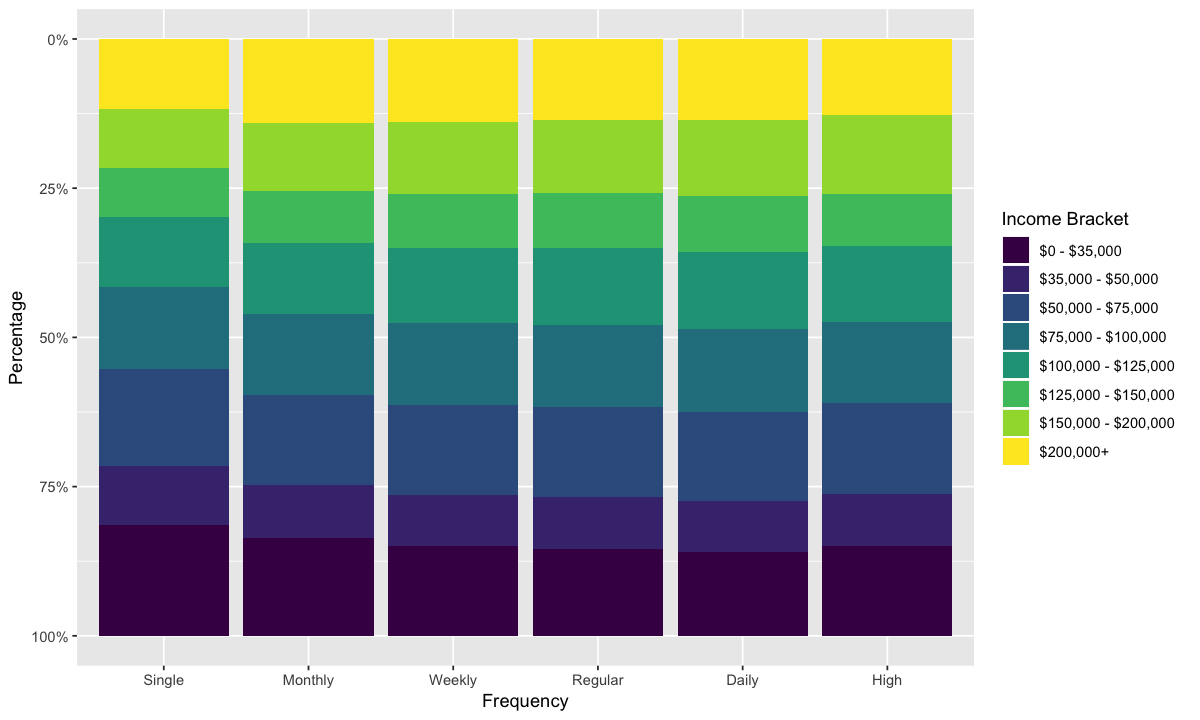

In [390]:
trips.2pct %>%
    filter(commercial == 0) %>%
    inc_distr_by(freq) %>%
plot_inc_stacked(xlab="Frequency") +
    scale_x_discrete(labels=c("Single", "Monthly", "Weekly", "Regular", "Daily", "High"))

In [356]:
inc_freq = trips.2pct %>%
    filter(commercial == 0) %>%
    inc_distr_by(freq) %>%
    inc_quantiles(c(0.05, 0.25, 0.5, 0.75, 0.95))

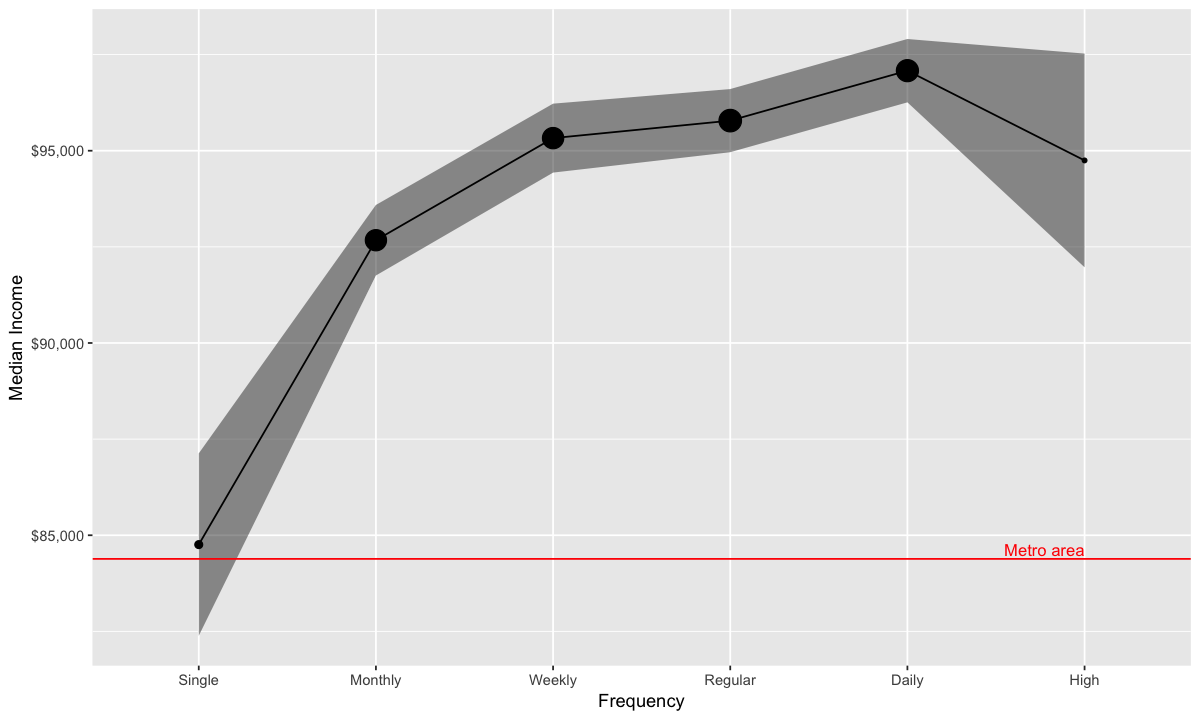

In [357]:
plot_med_inc(inc_freq, xlab="Frequency", ref_val=med_metro) + 
    scale_x_discrete(labels=c("Single", "Monthly", "Weekly", "Regular", "Daily", "High")) +
    annotate("text", x=6, y=med_metro+100, label="Metro area", 
             hjust="right", vjust="bottom", size=3.5, color="red")

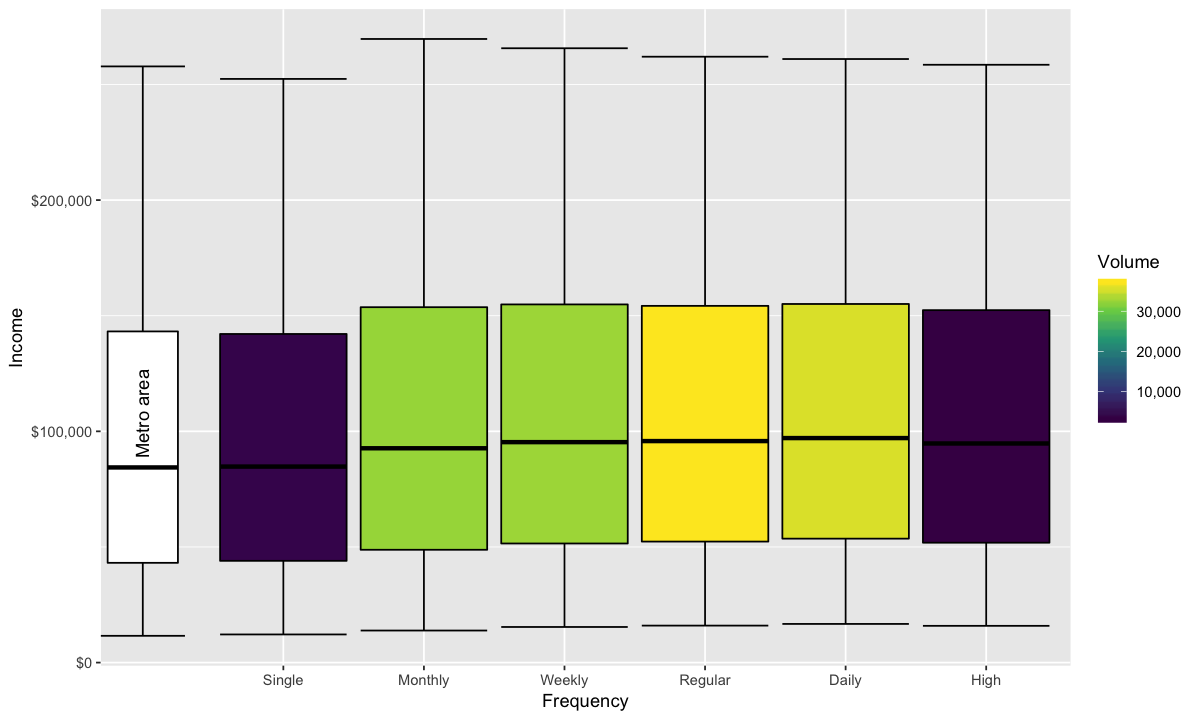

In [366]:
plot_inc_distr(inc_freq, xlab="Frequency", ref_distr=metro_qiles) +
    scale_x_discrete(labels=c("Single", "Monthly", "Weekly", "Regular", "Daily", "High")) 

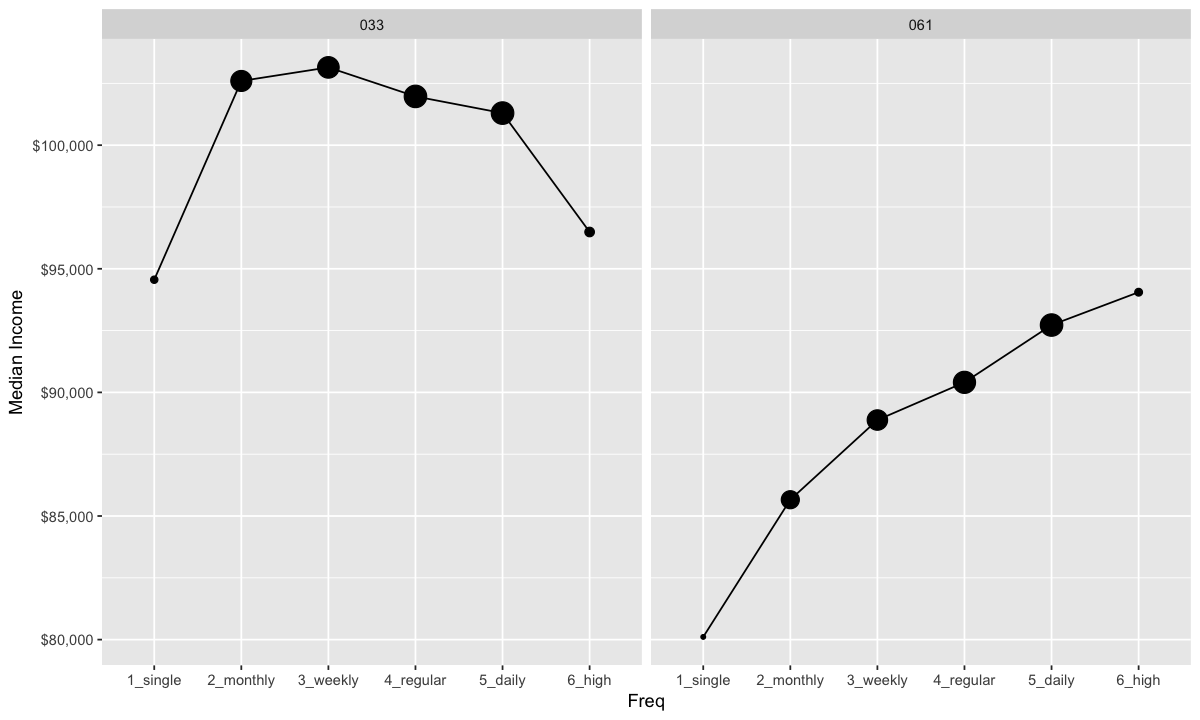

In [7]:
trips.2pct %>%
    filter(commercial == 0) %>%
    mutate(county = str_sub(fips, 3, 5)) %>%
    filter(county == "033" | county == "061") %>%
    inc_distr_by(freq, county) %>%
    inc_quantiles(0.5) %>%
plot_med_inc + facet_wrap("county")

## What is the distribution of income by time of day?

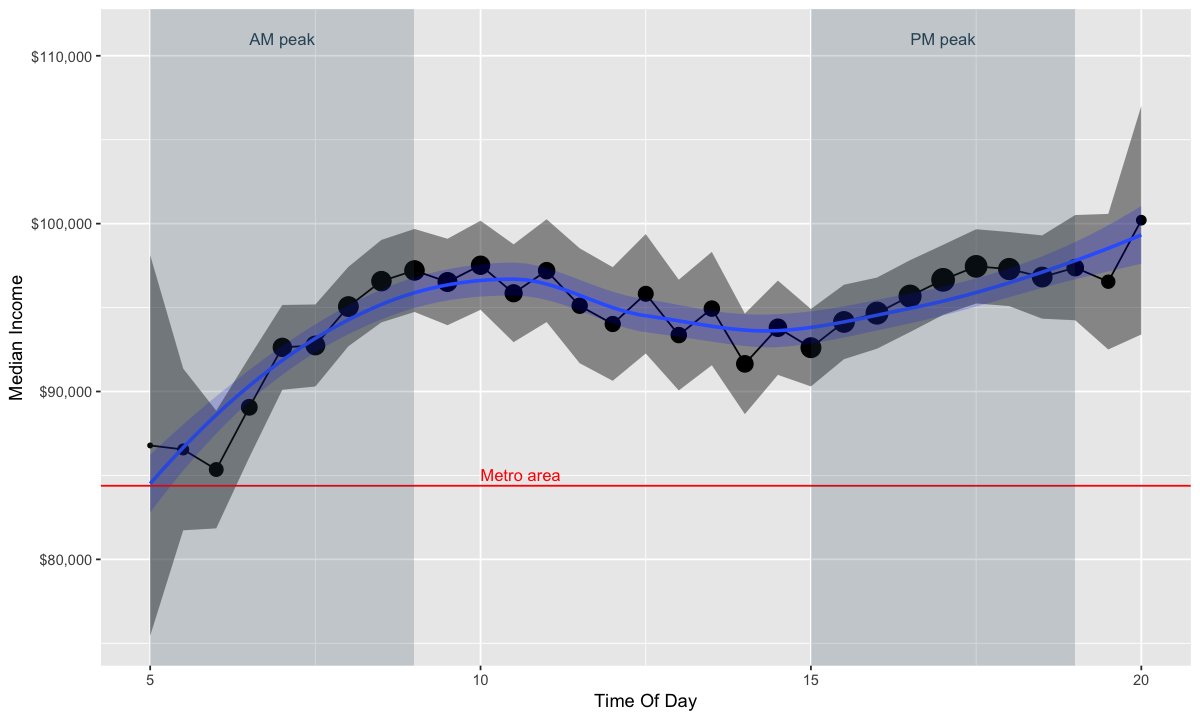

In [407]:
trips.2pct %>%
    mutate(entry_time = as_datetime(entry_time),
           time_of_day = hour(entry_time) + round(minute(entry_time)/30)/2) %>%
    filter(commercial == 0, is_hov == 0) %>%
    inc_distr_by(time_of_day) %>%
    inc_quantiles(0.5) %>%
plot_med_inc(trend=loess, ref_val=med_metro) +
    annotate("text", x=10, y=med_metro+300, label="Metro area",  
             hjust="left", vjust="bottom", size=3.5, color="red") + 
    annotate("rect", xmin=5, xmax=9, ymin=-Inf, ymax=Inf, alpha=0.2, fill="#335566") +
    annotate("rect", xmin=15, xmax=19, ymin=-Inf, ymax=Inf, alpha=0.2, fill="#335566") +
    annotate("text", x=7, y=111e3, label="AM peak", size=3.5, color="#335566") + 
    annotate("text", x=17, y=111e3, label="PM peak", size=3.5, color="#335566")

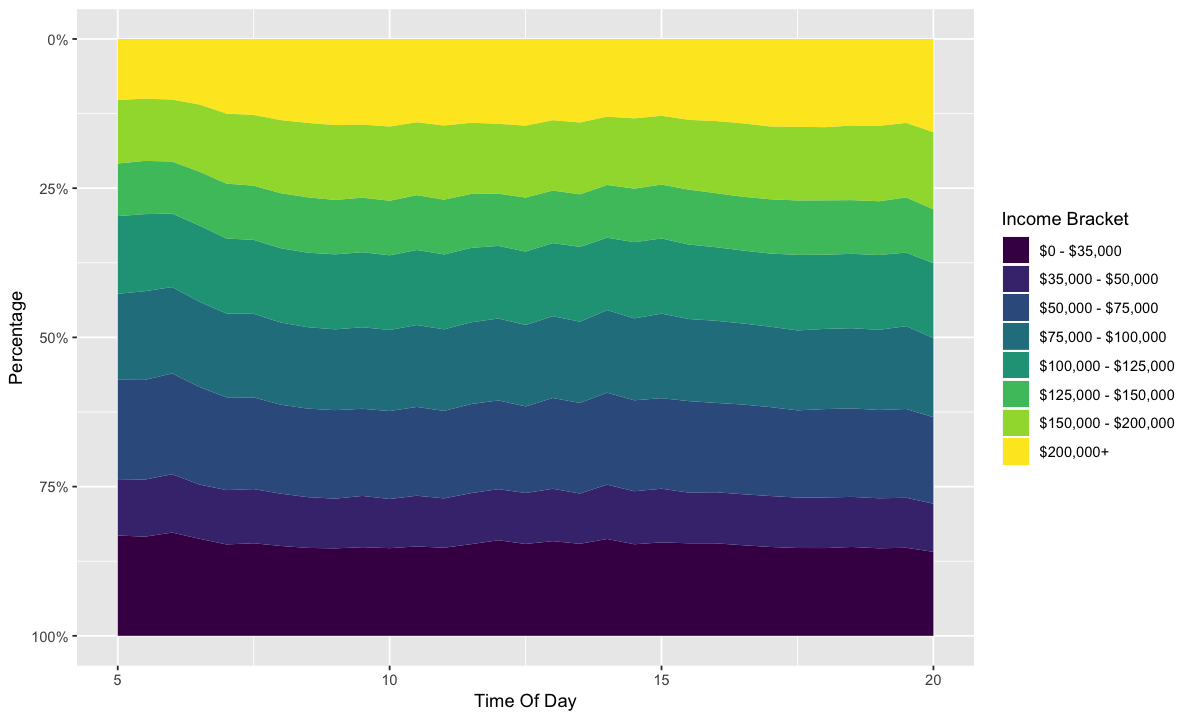

In [395]:
trips.2pct %>%
    mutate(entry_time = as_datetime(entry_time),
           time_of_day = hour(entry_time) + round(minute(entry_time)/30)/2) %>%
    filter(commercial == 0, is_hov == 0) %>%
    inc_distr_by(time_of_day) %>%
plot_inc_stacked

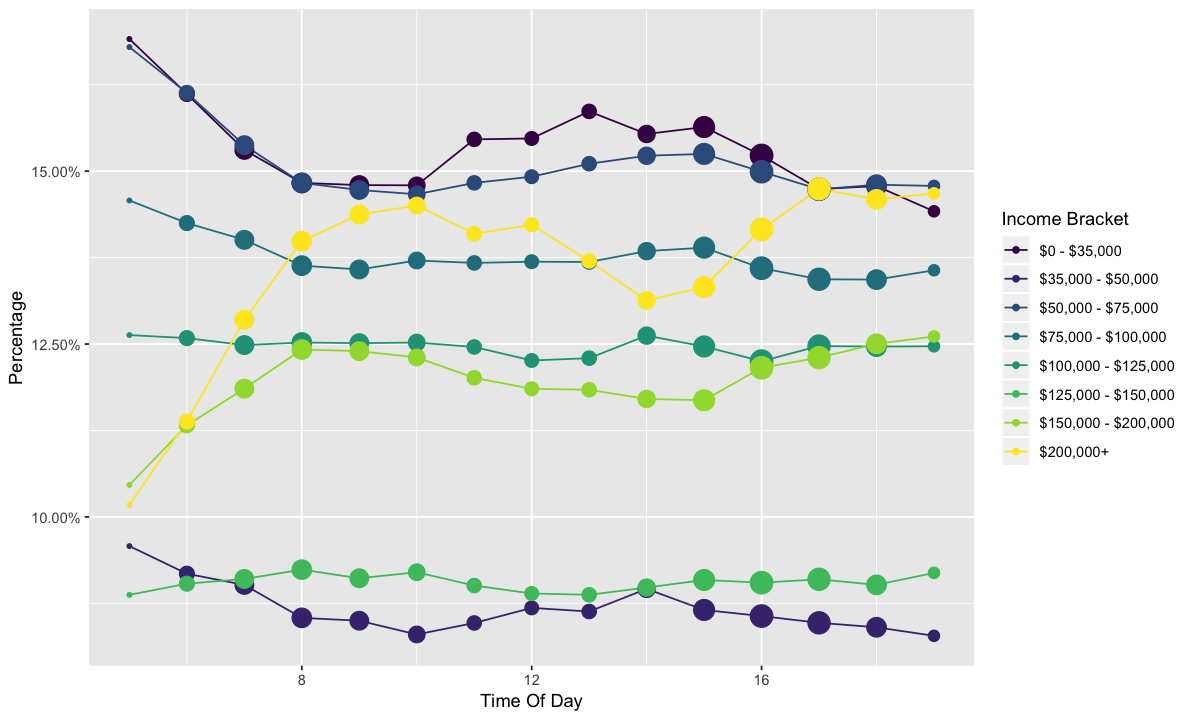

In [370]:
trips.2pct %>%
    mutate(entry_time = as_datetime(entry_time),
           time_of_day = hour(entry_time)) %>%
    filter(commercial == 0, is_hov == 0) %>%
    inc_distr_by(time_of_day) %>%
plot_inc_lines() + guides(size=F)

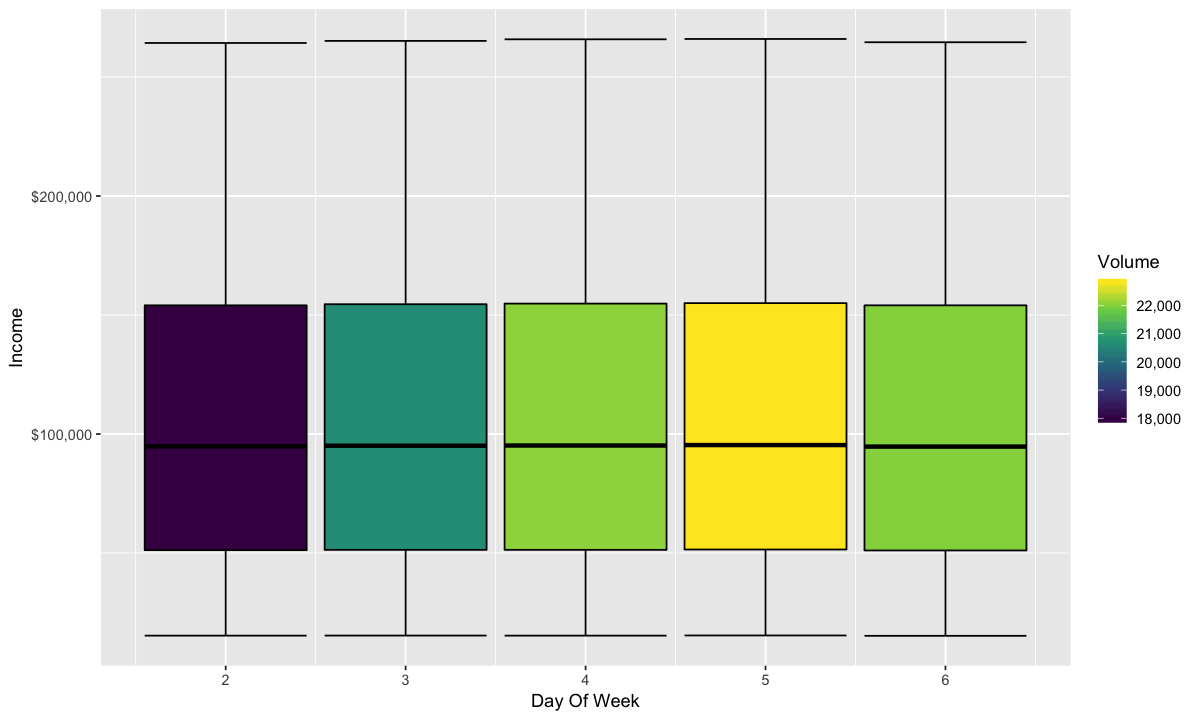

In [414]:
trips.2pct %>%
    mutate(entry_time = as_datetime(entry_time),
           day_of_week = wday(entry_time)) %>%
    filter(commercial == 0, is_hov == 0) %>%
    inc_distr_by(day_of_week) %>%
    inc_quantiles(c(0.05, 0.25, 0.5, 0.75, 0.95)) %>%
plot_inc_distr()# + scale_x_discrete(labels=c("Mon", "Tue", "Wed", "Thu", "Fri"))
#plot_med_inc(trend=loess, ref_val=med_metro) +
#    annotate("text", x=10, y=med_metro+300, label="Metro area",  
#             hjust="left", vjust="bottom", size=3.5, color="red")

## What is the distribution of income by toll?

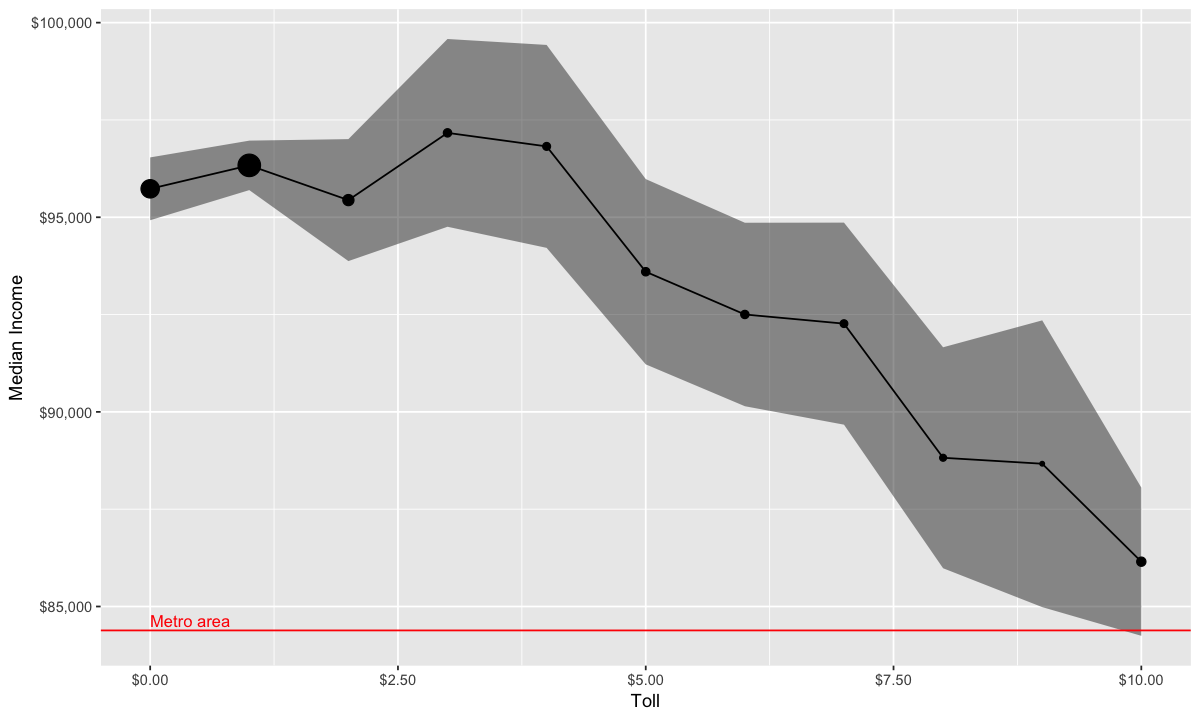

In [176]:
trips.2pct %>%
    filter(commercial == 0) %>%
    mutate(toll = ceiling(toll)) %>%
    inc_distr_by(toll) %>%
    inc_quantiles(0.5) %>%
plot_med_inc(ref_val=med_metro) + 
    scale_x_continuous(label=scales::dollar) + 
    annotate("text", x=0, y=med_metro+100, label="Metro area", 
             hjust="left", vjust="bottom", size=3.5, color="red")

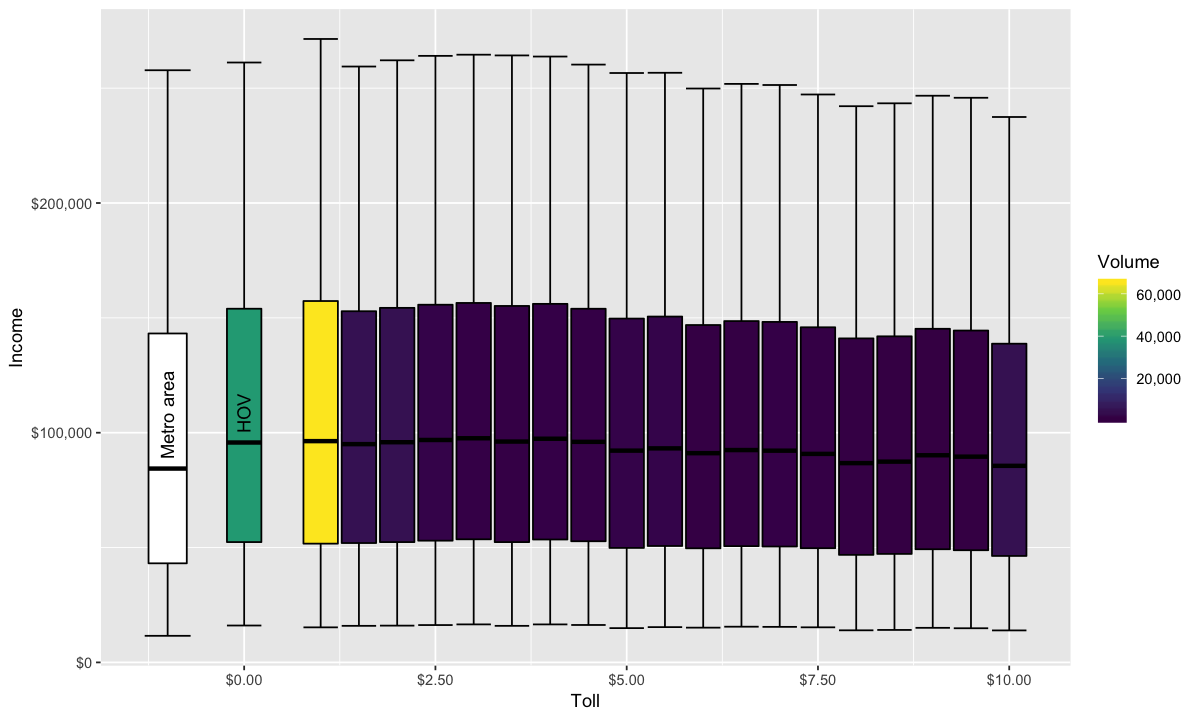

In [402]:
trips.2pct %>%
    filter(commercial == 0) %>%
    mutate(toll = ceiling(toll*2)/2) %>%
    inc_distr_by(toll) %>%
    inc_quantiles(c(0.05, 0.25, 0.5, 0.75, 0.95)) %>%
plot_inc_distr(ref_distr=metro_qiles, x_ref=-1) +
    scale_x_continuous(label=scales::dollar) + 
    annotate("text", x=0, y=100e3, angle=90, hjust="left", label="HOV")

# What is the distribution of HOV/SOV users by time of day?

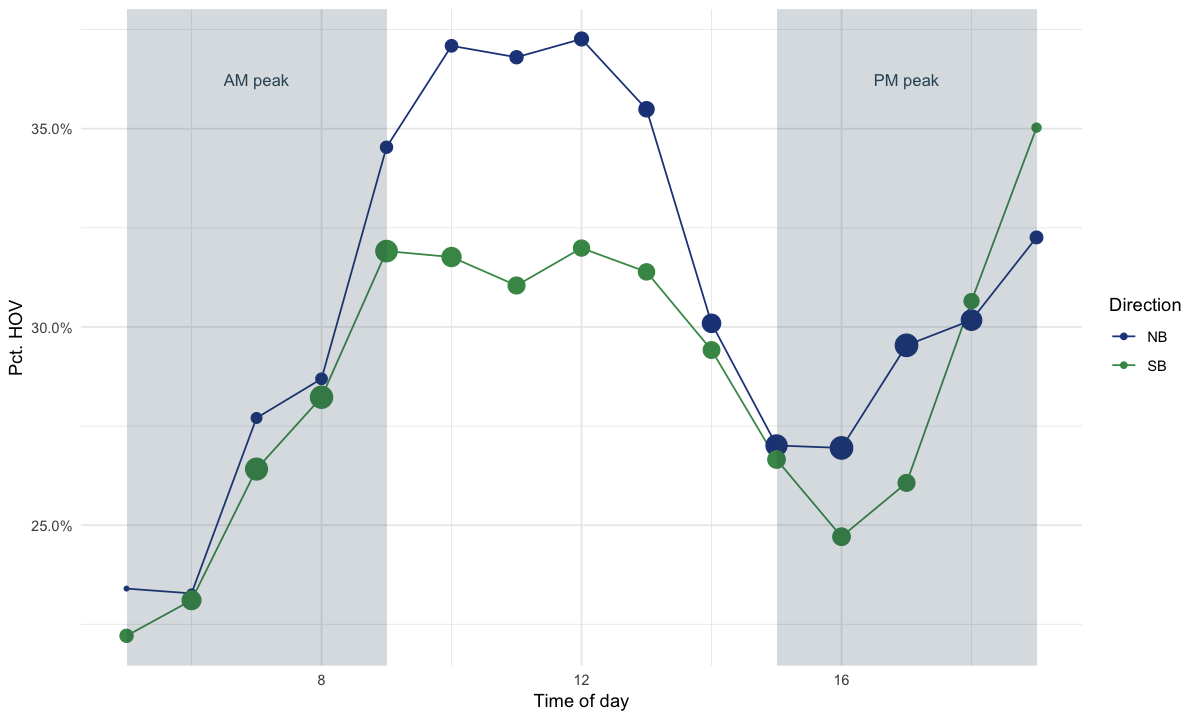

In [5]:
trips.2pct %>%
    mutate(direction = if_else(entry_plaza <= 12, "NB", "SB"),
           entry_time = as_datetime(entry_time),
           time_of_day = hour(entry_time)) %>% # + round(minute(entry_time)/30)/2) %>%
    group_by(direction, time_of_day, is_hov) %>%
    summarize(volume=n()) %>%
    group_by(direction, time_of_day) %>%
    mutate(pct_hov = volume/sum(volume),
           volume = sum(volume)) %>% 
    ungroup %>%
    filter(is_hov==1) %>%
ggplot(aes(time_of_day, pct_hov, color=direction, group=direction)) + 
    #facet_wrap("direction") +
    geom_line(aes(color=direction)) + 
    geom_point(aes(size=volume)) +
    guides(size=F) +
    scale_color_manual(values=c("#224488", "#449555")) +
    #scale_x_continuous(breaks=5:19) +
    scale_y_continuous(labels=scales::percent) +
    labs(x="Time of day", color="Direction", y="Pct. HOV") +
    annotate("rect", xmin=5, xmax=9, ymin=-Inf, ymax=Inf, alpha=0.2, fill="#335566") +
    annotate("rect", xmin=15, xmax=19, ymin=-Inf, ymax=Inf, alpha=0.2, fill="#335566") +
    annotate("text", x=7, y=0.3625, label="AM peak", size=3.5, color="#335566") + 
    annotate("text", x=17, y=0.3625, label="PM peak", size=3.5, color="#335566") + 
    theme_minimal()

ggsave("../../../img/hov_tod.png", width=6.5, height=3.5, dpi=320)

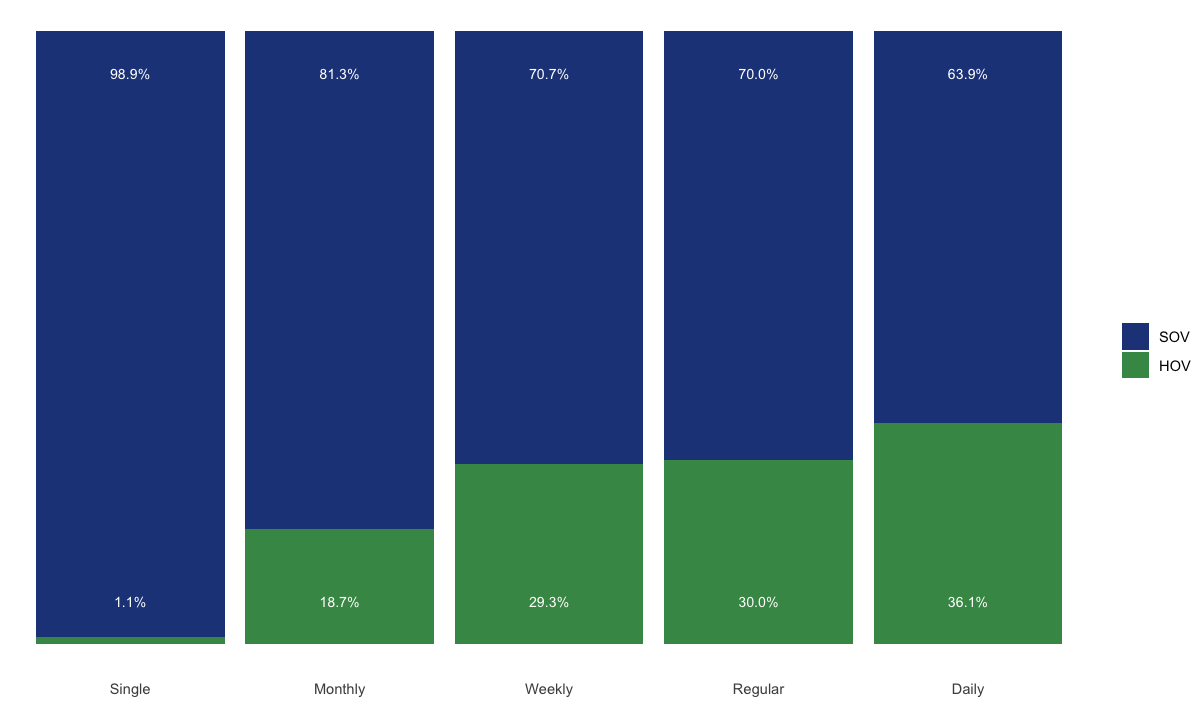

In [8]:
trips.2pct %>%
    mutate(direction = if_else(entry_plaza <= 12, "NB", "SB"),
           entry_time = as_datetime(entry_time),
           county = str_sub(as.character(fips), 3, 5),
           hour = hour(as_datetime(entry_time)),
           am_peak = hour >= 5 & hour < 9 & direction == "SB",
           pm_peak = hour >= 15 & hour < 19 & direction == "NB",
           peak = am_peak | pm_peak,
           time_of_day = hour(entry_time) + round(minute(entry_time)/30)/2,
           group = peak) %>%
    #filter(county == "033" | county == "061") %>%
    #group_by(freq, group, is_hov) %>%
    group_by(freq, is_hov) %>%
    summarize(volume=n()) %>%
    #group_by(freq, group) %>%
    group_by(freq) %>%
    mutate(pct_hov = volume/sum(volume),
           volume = sum(volume)) %>% 
    ungroup %>%
    filter(!is.na(freq), freq != "6_high") %>%
ggplot(aes(freq, pct_hov)) +
    geom_col(aes(fill=as_factor(is_hov))) + 
    scale_fill_manual(name="", labels=c("SOV", "HOV"), values=c("#224488", "#449555")) +
    geom_text(aes(y=if_else(is_hov==1, 0.07, 0.93), label=scales::percent(pct_hov)), color="white", size=3) +
    #geom_text(aes(y=0.95, label=scales::percent(pct_hov), alpha=1-is_hov), color="white", size=3) +
    scale_x_discrete(labels=function(x) str_to_title(str_sub(x, 3))) +
    labs(x="") + guides(alpha=F) +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text.y = element_blank(),
          axis.title.y = element_blank(),
          plot.margin = grid::unit(c(0,0,0,0), "mm"))
                     
ggsave("../../../img/hov_freq.png", width=6.5, height=3, dpi=320)

In [35]:
trips.2pct %>%
    mutate(direction = if_else(entry_plaza <= 12, "NB", "SB"),
           entry_time = as_datetime(entry_time),
           county = str_sub(as.character(fips), 3, 5),
           hour = hour(as_datetime(entry_time)),
           am_peak = hour >= 5 & hour < 9 & direction == "SB",
           pm_peak = hour >= 15 & hour < 19 & direction == "NB",
           peak = am_peak | pm_peak,
           time_of_day = hour(entry_time) + round(minute(entry_time)/30)/2,
           group = peak) %>%
    #filter(county == "033" | county == "061") %>%
    group_by(direction, peak, is_hov) %>%
    summarize(volume=n()) %>%
    group_by(direction, peak) %>%
    mutate(pct_hov = volume/sum(volume),
           volume = sum(volume)) %>% 
    ungroup %>%
    filter(is_hov==1)# %>%
ggplot(aes(direction, peak, color=pct_hov)) + 
    geom_point(aes(size=volume)) +
    scale_size_continuous(range = c(5, 20)) +
    guides(size=F)

direction,peak,is_hov,volume,pct_hov
<chr>,<lgl>,<dbl>,<int>,<dbl>
NB,FALSE,1,45675,0.3288232
NB,TRUE,1,62658,0.2837467
SB,FALSE,1,93432,0.2977138
SB,TRUE,1,48235,0.2589406


ERROR: Error: `data` must be a data frame, or other object coercible by `fortify()`, not an S3 object with class uneval
Did you accidentally pass `aes()` to the `data` argument?


In [33]:
trips.2pct %>%
    group_by(id, is_hov) %>%
    summarize(trips=n()) %>%
    drop_na() %>%
    spread(is_hov, trips) %>%
    rename(hov_trips=`1`, sov_trips=`0`) %>%
    ungroup() %>%
    add_tally(name="total") %>%
    group_by(hov_trips > 0, sov_trips > 0) %>%
    summarize(n()/mean(total))

hov_trips > 0,sov_trips > 0,n()/mean(total)
<lgl>,<lgl>,<dbl>
TRUE,TRUE,0.07588606
TRUE,NA,0.20085547
NA,TRUE,0.72325846
